In [9]:
#!pip3 install lfpykit

In [40]:
%matplotlib inline

# if you want a specific arbor load location after a custom cmake build
# from https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
import importlib
ARBOR_LOCATION = '/specialhome/lennart/Repos/arbor-sim/arbor/build/python/arbor/__init__.py'
spec = importlib.util.spec_from_file_location('arbor', ARBOR_LOCATION)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)

import random
import numpy as np
import matplotlib.pyplot as plt

import lfpykit
import arbor

import iopublic
iopublic.ARBOR_BUILD_CATALOGUE = '/specialhome/lennart/Repos/arbor-sim/arbor/build/arbor-build-catalogue'

In [2]:
recipe = iopublic.build_recipe(
    '2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be',
    spikes={}
)
recipe

<arbor.recipe>

In [ ]:
%%time

tfinal = 200
dt = 0.025
gpu_id = 1

context = arbor.context(threads=8, gpu_id=gpu_id)
domains = arbor.partition_load_balance(recipe, context)

sim = arbor.simulation(recipe, domains, context)

voltage_handles = [sim.sample((gid, 1), arbor.regular_schedule(1), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
current_handles = [sim.sample((gid, 2), arbor.regular_schedule(1), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]

sim.run(tfinal=tfinal, dt=dt)

voltage_traces = [sim.samples(handle)[0] for handle in voltage_handles]
current_traces = [sim.samples(handle)[0] for handle in current_handles]

In [ ]:
# each element of V_samples is [nsamples * (time, v(cv0), v(cv1), v(cv2))] etc
indss = [np.array([m.dist!=m.prox for m in tr[1]]) for tr in voltage_traces]
V_samples  = [tr[0][:, np.r_[True, inds]] for inds, tr in zip(indss, voltage_traces)]
V_meta = [np.array(tr[1])[inds].tolist() for inds, tr in zip(indss, voltage_traces)]
I_samples  = [x[0] for x in current_traces]
I_meta = [x[1] for x in current_traces]
for a,b  in zip(V_meta, I_meta):
    assert a == b
for a,b  in zip(V_samples, I_samples):
    assert (a[:, 0]==b[:, 0]).all()
time = V_samples[0][0]
V_m = [x[:,1:].T for x in V_samples]
I_m = [x[:,1:].T for x in I_samples]
print('There are', sum(map(len, V_m)), 'nonempty CVs')

In [10]:
# from https://github.com/LFPy/LFPykit/blob/master/examples/Example_Arbor_swc.ipynb

class ArborCellGeometry(lfpykit.CellGeometry):
    '''
    Class inherited from  ``lfpykit.CellGeometry`` for easier forward-model predictions in Arbor
    that keeps track of arbor.segment information for each CV. 
    
    Parameters
    ----------
    p: ``arbor.place_pwlin`` object
        3-d locations and cables in a morphology (cf. ``arbor.place_pwlin``)
    cables: ``list``
         ``list`` of corresponding ``arbor.cable`` objects where transmembrane 
         currents are recorded (cf. ``arbor.cable_probe_total_current_cell``)

    See also
    --------
    lfpykit.CellGeometry
    '''
    def __init__(self, p, cables):
        x, y, z, d = [np.array([], dtype=float).reshape((0, 2))] * 4
        CV_ind = np.array([], dtype=int)  # tracks which CV owns segment
        for i, m in enumerate(cables):
            segs = p.segments([m])
            for j, seg in enumerate(segs):
                x = np.row_stack([x, [seg.prox.x, seg.dist.x]])
                y = np.row_stack([y, [seg.prox.y, seg.dist.y]])
                z = np.row_stack([z, [seg.prox.z, seg.dist.z]])
                d = np.row_stack([d, [seg.prox.radius * 2, seg.dist.radius * 2]])
                CV_ind = np.r_[CV_ind, i]
                                
        super().__init__(x=x, y=y, z=z, d=d)
        self._CV_ind = CV_ind

class ArborLineSourcePotential(lfpykit.LineSourcePotential):
    '''subclass of ``lfpykit.LineSourcePotential`` modified for 
    instances of ``ArborCellGeometry``. 
    Each CV may consist of several segments , and this implementation 
    accounts for their contributions normalized by surface area, that is, 
    we assume constant transmembrane current density per area across each CV
    and constant current source density per unit length per segment 
    (inherent in the line-source approximation).
    
    Parameters
    ----------
    cell: object
        ``ArborCellGeometry`` instance or similar.
    x: ndarray of floats
        x-position of measurement sites (µm)
    y: ndarray of floats
        y-position of measurement sites (µm)
    z: ndarray of floats
        z-position of measurement sites (µm)
    sigma: float > 0
        scalar extracellular conductivity (S/m)
    
    See also
    --------
    lfpykit.LineSourcePotential
    '''
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._get_transformation_matrix = super().get_transformation_matrix
    
    def get_transformation_matrix(self):
        '''Get linear response matrix

        Returns
        -------
        response_matrix: ndarray
            shape (n_coords, n_CVs) ndarray
        '''
        M_tmp = self._get_transformation_matrix()
        n_CVs = np.unique(self.cell._CV_ind).size
        M = np.zeros((self.x.size, n_CVs))
        for i in range(n_CVs):
            inds = self.cell._CV_ind == i
            M[:, i] = M_tmp[:, inds] @ (self.cell.area[inds] / self.cell.area[inds].sum())
        
        return M

In [102]:
# find an interesting plane:
a = random.choice(recipe.neurons)
a = np.array([a.x, a.y, a.z])
b = random.choice(recipe.neurons)
b = np.array([b.x, b.y, b.z])
c = random.choice(recipe.neurons)
c = np.array([c.x, c.y, c.z])
u = b - a
v = c - a
point = np.array([a, b, c]).mean(0)
normal = np.cross(u, v)
normal = normal / np.linalg.norm(normal)
scale = np.array([np.linalg.norm(b - a), np.linalg.norm(c - a), np.linalg.norm(b - c)]).mean()
e0 = b - a
e1 = np.cross(e0, b)
e0 = e0 / np.linalg.norm(e0)
e1 = e1 / np.linalg.norm(e1)

# meshgrid that:
s = np.linspace(-scale*0.8, scale*0.8, 32)

Xplane, Yplane = np.meshgrid(s, s)
X, Y, Z = point[:, None] + \
    Xplane.flatten()[None, :]*e0[:, None] + \
    Yplane.flatten()[None, :]*e1[:, None]

In [103]:
%%time
lsps = []
Ms = []
geometries = []
for gid in range(recipe.num_cells()):
    segtree = recipe.cell_morphology(gid)
    p = arbor.place_pwlin(arbor.morphology(segtree))
    cell_geometry = ArborCellGeometry(p, I_meta[gid])
    lsp = ArborLineSourcePotential(cell=cell_geometry, x=X, y=Y, z=Z)
    M = lsp.get_transformation_matrix()
    geometries.append(cell_geometry)
    lsps.append(lsp)
    Ms.append(M)
    print(gid, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [104]:
%%time
# Extracellular potential in x,y-plane
# V_ext contains potential for each neurons
V_ext = np.array([Ms[gid] @ I_m[gid] for gid in range(recipe.num_cells()) if len(Ms) > gid])
# V_e sums up the individual neurons contributions
V_e = np.nan_to_num(V_ext).sum(0)

CPU times: user 1min 3s, sys: 18min 11s, total: 19min 15s
Wall time: 37.1 s


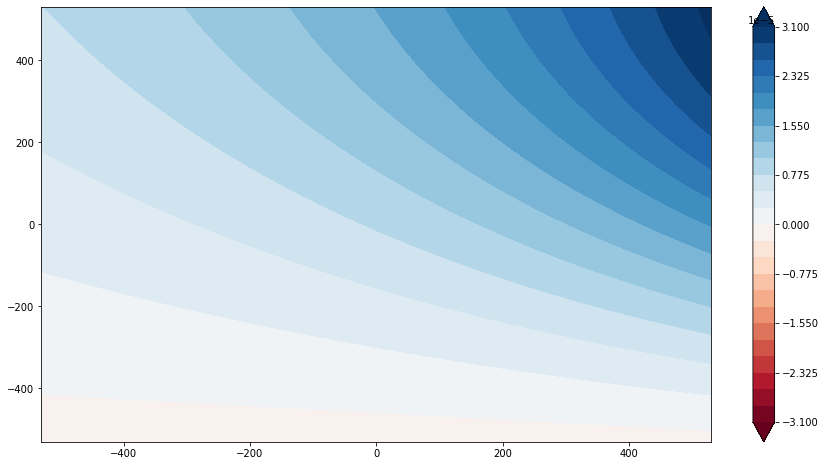

In [105]:
plt.figure(figsize=(15, 8))
lim = float(f'{abs(V_e).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
plt.contourf(Xplane, Yplane, V_e[:, -1].reshape(Xplane.shape), cmap='RdBu', levels=levels, extend='both')
plt.colorbar()

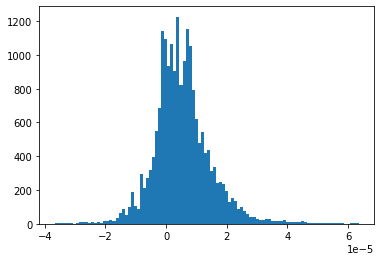

In [100]:
plt.hist(V_e.flatten(), bins=100);